## lc percent by place

In [41]:

import os
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.mask
import numpy as np
from shapely.geometry import mapping
from tqdm import tqdm

# Load NLCD 2020 land cover raster

dir_lc = 'E:/_data/LULC/NLCD_USA/'


nlcd_path = os.path.join(dir_lc, 'Annual_NLCD_LndCov_2020_CU_C1V0.tif')
nlcd = rasterio.open(nlcd_path)

# Get and print current working directory
cwd = os.path.dirname(os.getcwd())
print("Current working directory:", cwd)
# Load places data
f = os.path.join(cwd, "data", "aoi", "places_in_or_touching_metros_487.shp")
places_in_met_unique_mainland = gpd.read_file(f)


Current working directory: d:\natcap\invest-mental-health


NLCD land cover class codes for developed areas are:

21: Developed, Open Space

22: Developed, Low Intensity

23: Developed, Medium Intensity

24: Developed, High Intensity

In [42]:

# Ensure CRS matches
if places_in_met_unique_mainland.crs != nlcd.crs:
    places_proj = places_in_met_unique_mainland.to_crs(nlcd.crs)
else:
    places_proj = places_in_met_unique_mainland.copy()

# Develop land classes from NLCD
developed_classes = [21, 22, 23, 24]
developed_classes = [22, 23, 24]

# Create a new column to store % developed land
places_proj["pct_developed"] = np.nan

# Loop through each polygon and calculate % developed
for idx, row in tqdm(places_proj.iterrows(), total=len(places_proj)):
    geom = [mapping(row.geometry)]
    
    try:
        out_image, out_transform = rasterio.mask.mask(nlcd, geom, crop=True)
        out_image = out_image[0]  # first band

        if out_image.size > 0:
            valid_pixels = out_image[out_image != nlcd.nodata]
            total_pixels = len(valid_pixels)
            if total_pixels > 0:
                developed_pixels = np.isin(valid_pixels, developed_classes).sum()
                percent_developed = (developed_pixels / total_pixels) * 100
                places_proj.at[idx, "pct_developed"] = round(percent_developed, 2)
    except Exception as e:
        print(f"Failed at index {idx}: {e}")
        continue

# Done
print("✅ Completed calculation.")


100%|██████████| 487/487 [00:08<00:00, 56.12it/s] 

✅ Completed calculation.


Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID_l', 'GEOID_PLAC',
       'NAME_PLACE', 'NAMELSAD_l', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'SUMLEV', 'STATE', 'PLACE', 'POP2020_le', 'POP2021_le',
       'POP2022_le', 'POP2023_le', 'POP2024_le', 'POP_KM2_le', 'CSAFP',
       'CBSAFP', 'METDIVFP', 'AFFGEOID_r', 'GEOID_METR', 'NAME_METRO',
       'NAMELSAD_r', 'LSAD_x', 'MDIV', 'LSAD_y', 'SBASE2020', 'POP2020_ri',
       'POP2021_ri', 'POP2022_ri', 'POP2023_ri', 'POP2024_ri', 'GEOID_MDIV',
       'POP_KM2_ri', 'count', 'level', 'AFFGEOID', 'NAMELSAD', 'POP2020',
       'POP2021', 'POP2022', 'POP2023', 'POP2024', 'POP_KM2', 'geometry',
       'pct_developed'],
      dtype='object')
Summary of % Developed Land:
count    487.000000
mean      74.796181
std       14.424095
min       25.760000
25%       65.550000
50%       74.940000
75%       85.525000
max       99.780000
Name: pct_developed, dtype: float64


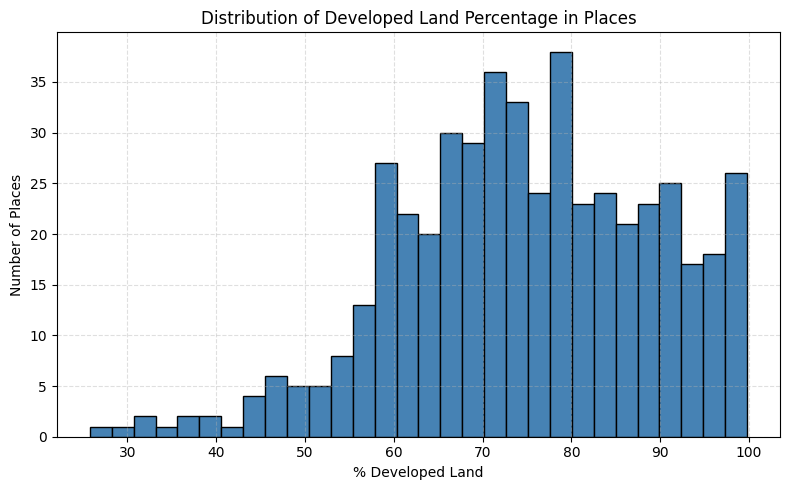

dev_category
High (>70%)        310
Medium (30–70%)    176
Low (<30%)           1
Name: count, dtype: int64


In [43]:
print(places_proj.columns)


# Drop 'col1' and 'col3' and create a new DataFrame
places_final = places_proj.drop([
    'AFFGEOID', 'NAMELSAD', 'POP2020',
    'POP2021', 'POP2022', 'POP2023', 'POP2024', 'POP_KM2',
    'NAMELSAD_r', 'LSAD_x', 'MDIV', 'LSAD_y', 'SBASE2020'], 
    errors='ignore',  # Ignore if columns don't exist
    axis=1)


# print(places_final[["GEOID_PLAC", "NAME_PLACE", "pct_developed"]].head())

## Summary Statistics ------ 
summary_stats = places_proj['pct_developed'].describe()
print("Summary of % Developed Land:")
print(summary_stats)



## Histogram of % Developed Land -------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(places_proj['pct_developed'].dropna(), bins=30, color='steelblue', edgecolor='black')
plt.xlabel('% Developed Land')
plt.ylabel('Number of Places')
plt.title('Distribution of Developed Land Percentage in Places')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# Classify development categories

def classify_dev(p):
    if pd.isna(p): return 'Unknown'
    elif p < 30: return 'Low (<30%)'
    elif p <= 70: return 'Medium (30–70%)'
    else: return 'High (>70%)'

places_proj['dev_category'] = places_proj['pct_developed'].apply(classify_dev)
print(places_proj['dev_category'].value_counts())




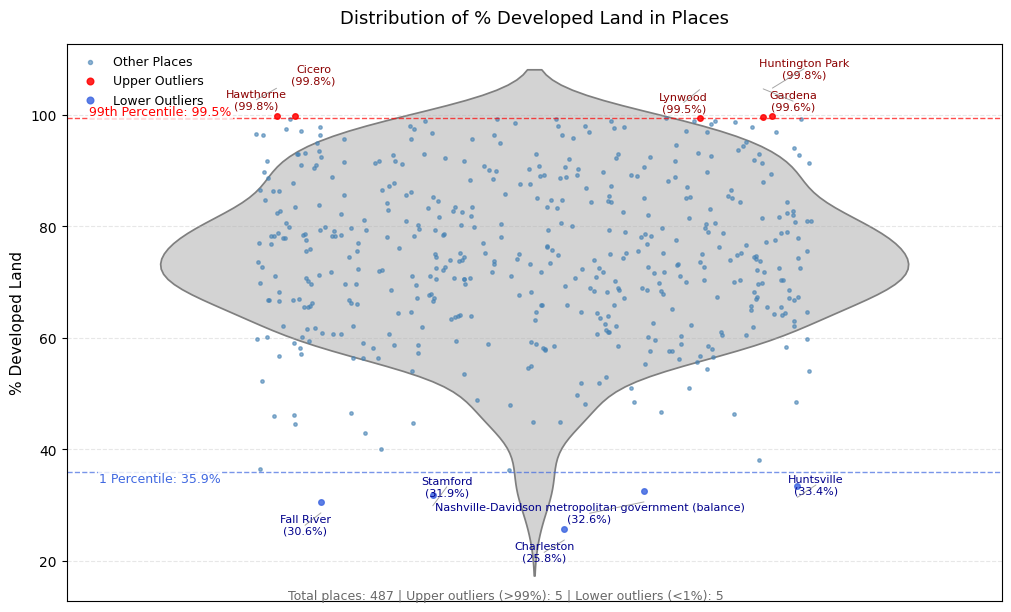

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from adjustText import adjust_text

# 1. Prepare data
df = places_proj[['NAME_PLACE', 'pct_developed']].dropna().copy()

# 2. Add consistent jitter for points
np.random.seed(42)
df['jitter'] = np.random.uniform(-0.3, 0.3, len(df))

# 3. Define outlier thresholds (top/bottom 1%)
quan_pct = 99
upper_thresh = df['pct_developed'].quantile(quan_pct/100)
lower_thresh = df['pct_developed'].quantile(1-quan_pct/100)

# 4. Mark outliers (use jittered df!)
upper_out = df[df['pct_developed'] > upper_thresh]
lower_out = df[df['pct_developed'] < lower_thresh]
outliers = pd.concat([upper_out, lower_out])
base = df[~df.index.isin(outliers.index)]

# 5. Setup plot
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.violinplot(y='pct_developed', data=df, inner=None, color='lightgray', ax=ax)

# 6. Plot all base points (non-outliers) in steelblue
ax.scatter(base['jitter'], base['pct_developed'], s=6, color='steelblue', alpha=0.6, zorder=2, label='Other Places')

# 7. Plot outlier points with different colors
ax.scatter(upper_out['jitter'], upper_out['pct_developed'], s=16, color='red', alpha=0.85, zorder=3, label='Upper Outliers')
ax.scatter(lower_out['jitter'], lower_out['pct_developed'], s=16, color='royalblue', alpha=0.85, zorder=3, label='Lower Outliers')

# 8. Draw threshold lines and annotate
ax.axhline(upper_thresh, color='red', linestyle='--', alpha=0.7, linewidth=1)
ax.axhline(lower_thresh, color='royalblue', linestyle='--', alpha=0.7, linewidth=1)

ax.text(0.1, upper_thresh, f'{quan_pct}th Percentile: {upper_thresh:.1f}%', ha='center', va='bottom',
        transform=ax.get_yaxis_transform(), fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))
ax.text(0.1, lower_thresh, f'{100-quan_pct}th Percentile: {lower_thresh:.1f}%', ha='center', va='top',
        transform=ax.get_yaxis_transform(), fontsize=9, color='royalblue', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

# 9. Prepare annotation texts for outliers (avoid overlap)
texts = []
for idx, row in outliers.iterrows():
    x = row['jitter']
    y = row['pct_developed']
    color = 'darkred' if y > upper_thresh else 'darkblue'
    # texts.append(ax.text(x, y, f"{row['NAME_PLACE']}\n({y:.1f}%)", fontsize=8, color=color, ha='center', va='center'))
    # Set initial offset
    if y > upper_thresh:
        y_text = y + 5  # Move 2 units above (adjust as needed)
    else:
        y_text = y - 2  # Move 2 units below (adjust as needed)
    texts.append(ax.text(x, y_text, f"{row['NAME_PLACE']}\n({y:.1f}%)", fontsize=8,
                         color=color, ha='center', va='center'))

# 10. Adjust annotations to avoid overlap
# adjust_text(
#     texts, ax=ax, 
#     expand_points=(1.2, 1.2), # Expand by 20% in both the x and y directions. space to expand around each data point to keep annotations from crowding them
#     expand_text=(1.2, 1.2),   # Expands the area around each label by 20% in both x and y, so labels don’t overlap each other.
#     arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.7),
#     force_text=(0.5, 0.5),   # How much force to use to push text labels away from overlaps (relative strength). 0.5 is moderate.
#     force_points=(0.8, 0.8), # How much force to use to push labels away from overlapping points.
#     only_move={'text': 'xy', 'points': 'xy'}, # text labels can move in both x and y.
#     lim=150
# )


adjust_text(
    texts, ax=ax,
    expand_points=(2, 2),     # push further away from points
    expand_text=(1.5, 1.5),   # also avoid text overlap
    arrowprops=dict(
        arrowstyle='-',
        color='gray',
        alpha=0.7,
        lw=0.7,
        shrinkA=0, # Shrink arrow at the text end
        shrinkB=0  # <-- ensures the arrow starts right at the point
    ),
    force_text=(0.5, 0.5),
    force_points=(1, 1),          # stronger force away from points
    only_move={'text': 'xy', 'points': 'xy'},
    lim=200
)


# 11. Final formatting
ax.set_ylabel('% Developed Land', fontsize=11)
ax.set_title('Distribution of % Developed Land in Places', fontsize=13, pad=15)
ax.set_xlim(-0.5, 0.5)
ax.set_xticks([])
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

# Optional: Add informative caption
fig.text(0.5, 0.01,
         f"Total places: {len(df)} | Upper outliers (>99%): {len(upper_out)} | "
         f"Lower outliers (<1%): {len(lower_out)}",
         ha='center', fontsize=9, color='dimgray')

# Optional: Add legend for point colors
ax.legend(loc='upper left', frameon=False, fontsize=9, markerscale=1.2)

plt.show()
